Nilai yang dicari menggunakan Keras Tuner adalah:
- learning rate ✅
- epoch ✅
- steps per epoch ✅
- validation steps ✅

#install dan import Libraries

In [ ]:
#install Keras Tuner
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Load Dataset

In [ ]:
# connect GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/db-kck-rgb/tanpa-augmentasi/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/db-kck-rgb/tanpa-augmentasi/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/db-kck-rgb/tanpa-augmentasi/test'

In [ ]:
# Membuat generator data pelatihan dan validasi
train_generator = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=10, class_mode='categorical')
valid_generator = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=10, class_mode='categorical')
test_generator = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=10, shuffle=False, class_mode='categorical')

Found 415 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
Found 57 images belonging to 3 classes.


#Define the model

In [ ]:
def model_build(hp):
  # Create MobileNetV2 dan add dense layer (3)
  mobile = MobileNetV2(weights='imagenet')
  x = mobile.layers[-1].output
  predictions = Dense(3, activation='softmax')(x)
  model = Model(inputs=mobile.input, outputs=predictions)

  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

  # Tune steps_per_epoch and validation_steps
  hp_steps_per_epoch = hp.Int('steps_per_epoch', min_value=37, max_value=57, step=5)
  hp_validation_steps = hp.Int('validation_steps', min_value=10, max_value=16, step=2)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_build,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=2,
                     directory='my_dir',
                     project_name='fdefect_detection')

14536120/14536120 [==============================] - 2s 0us/step


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_generator, validation_data=valid_generator, epochs=35, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 21 Complete [00h 00m 49s]
val_accuracy: 0.44736841320991516

Best val_accuracy So Far: 0.9210526347160339
Total elapsed time: 00h 19m 32s

The hyperparameter search is complete. The optimal learning rate for the optimizer is 0.0001.



In [ ]:
# Mengambil nilai hyperparameter terbaik
best_learning_rate = best_hps.get('learning_rate')
best_steps_per_epoch = best_hps.get('steps_per_epoch')
best_validation_steps = best_hps.get('validation_steps')

# Menampilkan hasil
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best steps_per_epoch: {best_steps_per_epoch}")
print(f"Best validation_steps: {best_validation_steps}")

Best learning_rate: 0.0001
Best steps_per_epoch: 42
Best validation_steps: 12


Ini adalah batas sesi 1 Colab. Sesi berakhir karena mengalami "crashed" akibat keterbatasan RAM yang tersedia. Disarankan untuk menggunakan Colab Pro.

# SESI 2 -> training menggunakan nilai best hps()

*   Best val_accuracy So Far: 0.9210526347160339
*   Total elapsed time: 00h 19m 32s


Berikut nilai best hps() dari sesi 1 Colab:
*   Best learning_rate: 0.0001
*   Best steps_per_epoch: 42
*   Best validation_steps: 12

Pada sesi kedua ini akan menggunakan nilai learning rate, steps per epoch dan validation steps yang didapatkan pada Sesi 1.
Kemudian pada sesi kedua ini akan dilakukan pencarian nilai epoch terbaik.

In [ ]:
def model_build(hp):
  # Create MobileNetV2 dan add dense layer (3)
  mobile = MobileNetV2(weights='imagenet')
  x = mobile.layers[-1].output
  predictions = Dense(3, activation='softmax')(x)
  model = Model(inputs=mobile.input, outputs=predictions)

  # Tune the number of epochs
  hp_epochs = hp.Int('epochs', min_value=10, max_value=40, step=5)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

  return model

In [ ]:
# Instantiate the tuner and perform hypertuning
tuner = kt.Hyperband(model_build,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='my_dir',
                     project_name='my_project3')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_generator, validation_data=valid_generator, epochs=35, callbacks=[stop_early])

Trial 7 Complete [00h 00m 40s]
val_accuracy: 0.8421052694320679

Best val_accuracy So Far: 0.8421052694320679
Total elapsed time: 00h 04m 41s


In [ ]:
# Mengambil nilai hyperparameter terbaik
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_epochs = best_hps.get('epochs')

# Menampilkan hasil
print(f"Best epochs: {best_epochs}")

Best epochs: 40


In [ ]:
best_model = model_build(best_hps)

In [ ]:
# Retrain the model (menggunakan best_epoch)
history = best_model.fit(train_generator, validation_data=valid_generator, epochs=best_epochs,
               steps_per_epoch=42, validation_steps=12)

Epoch 1/40
42/42 [==============================] - 32s 132ms/step - loss: 1.0892 - accuracy: 0.6554 - val_loss: 1.0932 - val_accuracy: 0.4474
Epoch 2/40
42/42 [==============================] - 4s 102ms/step - loss: 1.0550 - accuracy: 0.8410 - val_loss: 1.0554 - val_accuracy: 0.8246
Epoch 3/40
42/42 [==============================] - 4s 86ms/step - loss: 1.0316 - accuracy: 0.8988 - val_loss: 1.0753 - val_accuracy: 0.4912
Epoch 4/40
42/42 [==============================] - 5s 113ms/step - loss: 1.0153 - accuracy: 0.9518 - val_loss: 1.0772 - val_accuracy: 0.4386
Epoch 5/40
42/42 [==============================] - 6s 140ms/step - loss: 1.0108 - accuracy: 0.9422 - val_loss: 1.0529 - val_accuracy: 0.5789
Epoch 6/40
42/42 [==============================] - 5s 123ms/step - loss: 1.0027 - accuracy: 0.9566 - val_loss: 1.0168 - val_accuracy: 0.9035
Epoch 7/40
42/42 [==============================] - 4s 95ms/step - loss: 1.0012 - accuracy: 0.9301 - val_loss: 1.0352 - val_accuracy: 0.8070
Epoch 8

In [ ]:
#Evaluasi model menggunakan data uji
eval_result = best_model.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

6/6 [==============================] - 18s 3s/step - loss: 0.8446 - accuracy: 0.9825
[test loss, test accuracy]: [0.8445785045623779, 0.9824561476707458]


#Grafik hasil training dan validation

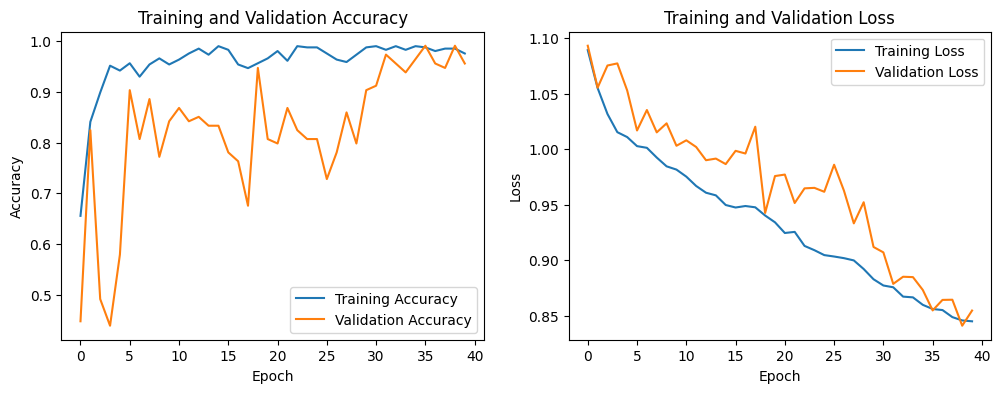

In [ ]:
import matplotlib.pyplot as plt

# Mendapatkan histori pelatihan dari hypermodel
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting akurasi pelatihan dan validasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss pelatihan dan validasi
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Menampilkan grafik
plt.show()

#Testing model

In [ ]:
test_labels = test_generator.classes
test_labels

test_generator.class_indices
predictions = best_model.predict(test_generator, verbose=0)

In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confutsion Matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalized=True'.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.tittle=(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix without normalization")
  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix without normalization
[[19  0  0]
 [ 0 19  0]
 [ 0  1 18]]


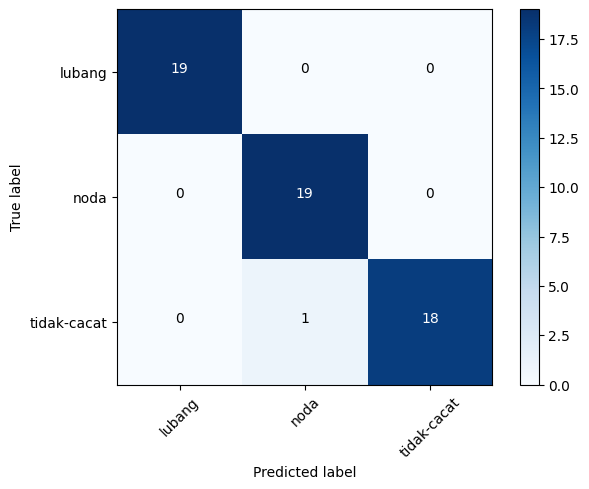

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['lubang', 'noda', 'tidak-cacat']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

**MENGHITUNG AKURASI**

In [ ]:
pred_labels = predictions.argmax(axis=1)

# Menampilkan pred_labels
print(pred_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# pred_labels: array label prediksi
# test_labels: array label ground truth
accuracy = accuracy_score(test_labels, pred_labels)

# menghitung F1-score, recall dan precision
report = classification_report(test_labels, pred_labels)

print("Akurasi: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", report)

Akurasi: 98.25%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.95      1.00      0.97        19
           2       1.00      0.95      0.97        19

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



#Save model

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/tugas-akhir/mobilenetv2-hyperparameter-otomatis/save-model/Salinan2-kerastuner-25jan.h5'
best_model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow import lite

model_h5 = tf.keras.models.load_model(save_path)

# Membuat konverter
converter = lite.TFLiteConverter.from_keras_model(model_h5)

# Mengonversi model
tflite_model = converter.convert()

# Menyimpan model
with open('/content/drive/MyDrive/Colab Notebooks/tugas-akhir/mobilenetv2-hyperparameter-otomatis/save-model/Salinan2-kerastuner-25jan.tflite', 'wb') as f:
    f.write(tflite_model)